In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
from classical_approach import *

## The Data

Just doing some quick investigation of the data. It appears that there are 79 galaxies/halos in total. The data to read in is a tuple: `(particle_info, halo_info)`.

The quantity we would like to predict is `GroupStellarMass`, I believe.

In [3]:
with open(halos_path, "rb") as f:
  particles, halo_slice  = pickle.load(f)

train_indices, test_indices = train_test_split(jnp.arange(len(particles)), test_size=0.5, random_state=42)

labels = jnp.log10(
    halo_slice["GroupStellarMass"] * 1e10 / 0.677
)  # label by logMstar
logc = jnp.log10(
    halo_slice["SubhaloVmax"]
    / jnp.sqrt(G * halo_slice["Group_M_Mean200"] / halo_slice["Group_R_Mean200"])
)
logm = jnp.log10(jnp.array([particle["count"] for particle in particles]))


train_labels, test_labels = labels[train_indices], labels[test_indices]
train_logc, test_logc = logc[train_indices], logc[test_indices]
train_logm, test_logm = logm[train_indices], logm[test_indices]

In [70]:
def linear_regression(x_data, y_data=None):
    std = sample("std", dist.Exponential(1))
    intercept = sample("intercept", dist.Normal(0, 3))
    slopes = sample("slopes", dist.Normal(0, 3), sample_shape=(x_data.shape[-1],))
    
    mean_predictions = intercept + (x_data @ slopes)

    return sample("predictions", dist.Normal(mean_predictions, std), obs=y_data)


train_x = jnp.stack([train_logc, train_logm], axis=-1)
test_x = jnp.stack([test_logc, test_logm], axis=-1)
mean_x = train_x.mean(axis=0, keepdims=True)
std_x = train_x.std(axis=0, keepdims=True)

train_transformed = (train_x - mean_x) / std_x
test_transformed = (test_x - mean_x) / std_x

nuts_kernel = NUTS(linear_regression)


mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=1000, num_chains=1)
mcmc.run(rng, train_transformed, train_labels)
samples = mcmc.get_samples()

# linear_regression = LinearRegression()


# linear_regression.fit(jnp.stack([train_logc, train_logm], axis=-1), train_labels)

sample: 100%|██████████| 5000/5000 [00:03<00:00, 1397.22it/s, 3 steps of size 6.51e-01. acc. prob=0.92]


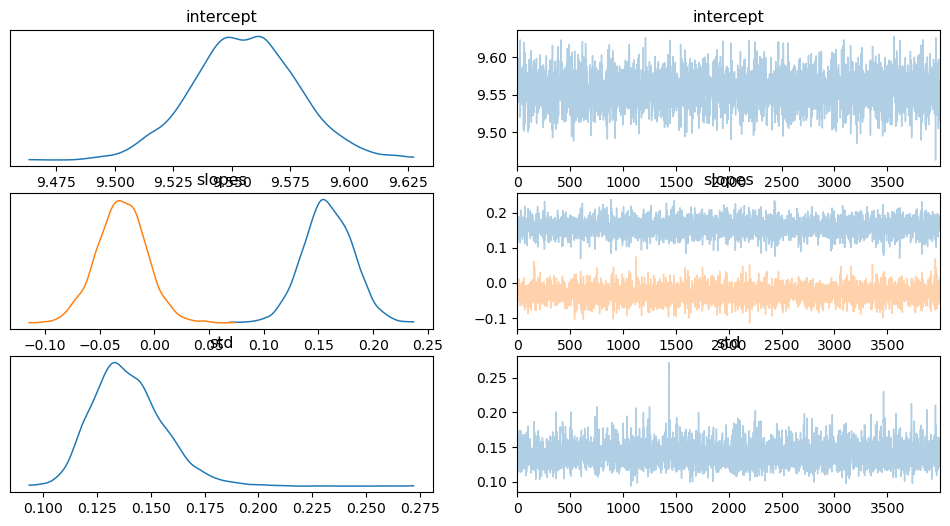

In [71]:
posterior = az.from_numpyro(mcmc)
az.plot_trace(posterior);
# az.plot_pair(posterior)

In [72]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept      9.56      0.02      9.56      9.52      9.59   4199.95      1.00
  slopes[0]      0.16      0.02      0.16      0.12      0.20   3824.69      1.00
  slopes[1]     -0.03      0.02     -0.03     -0.07      0.01   3761.97      1.00
        std      0.14      0.02      0.14      0.11      0.16   3308.60      1.00

Number of divergences: 0


In [73]:
# samples
predictive_distribution = Predictive(linear_regression, samples)

mins = train_transformed.min(axis=0)
maxs = train_transformed.max(axis=0)

example_pts = jnp.array([jnp.linspace(mins[0], maxs[0], 100), jnp.zeros([100])]).T

posterior_predictive = predictive_distribution(rng, example_pts)
# example_pts.shape

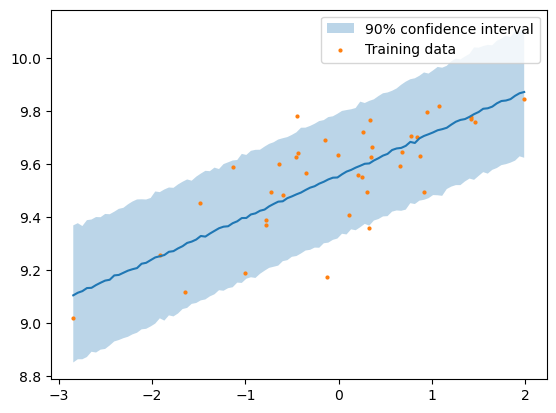

In [75]:

quantiles = jnp.quantile(posterior_predictive["predictions"], q=jnp.array([0.05, 0.5, 0.95]), axis=0)

fig, ax = plt.subplots()

# ax.scatter(train_labels, quantiles[1] - train_labels, s=4)

ax.plot(example_pts[:, 0], quantiles[1])
ax.fill_between(example_pts[:, 0], quantiles[0], quantiles[2], alpha=0.3, label="90% confidence interval")

ax.scatter(train_transformed[:, 0], train_labels, s=4, label="Training data")
# example_pts
ax.legend();

[Text(0.5, 0, 'logMstar'),
 Text(0, 0.5, 'Residuals'),
 Text(0.5, 1.0, 'Residuals vs logMstar')]

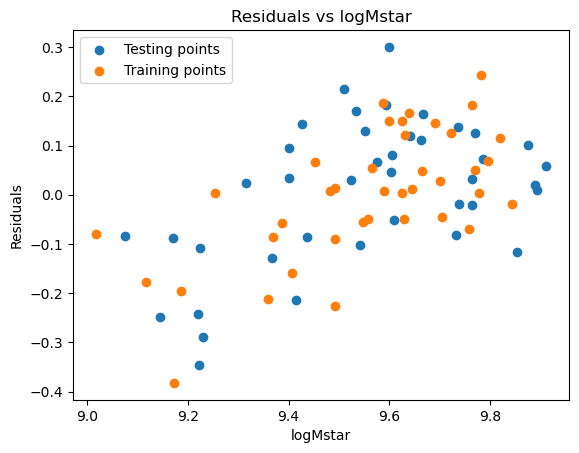

In [25]:
test_pred = linear_regression.predict(jnp.stack([test_logc, test_logm], axis=-1))
residuals = test_labels - test_pred

fig, ax = plt.subplots()

ax.scatter(test_labels, residuals, label="Testing points")
ax.scatter(train_labels, train_labels - linear_regression.predict(jnp.stack([train_logc, train_logm], axis=-1)), label="Training points")

ax.legend()

ax.set(xlabel="logMstar", ylabel="Residuals", title="Residuals vs logMstar")

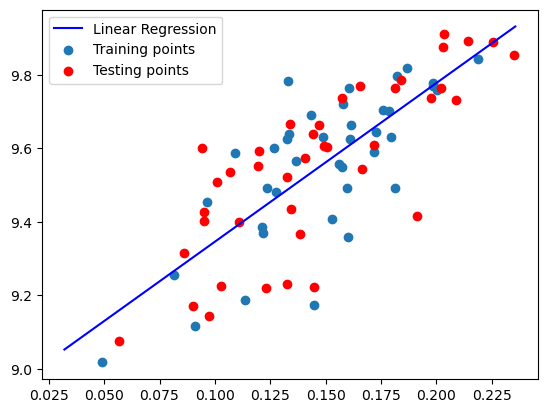

In [7]:
plt.plot(log_cs, preds, color="blue", label="Linear Regression")
plt.scatter(train_logc, train_labels, label="Training points")

plt.scatter(test_logc, test_labels, label="Testing points", color="red")

plt.legend()


In [6]:
example = particles[0]["Coordinates"]

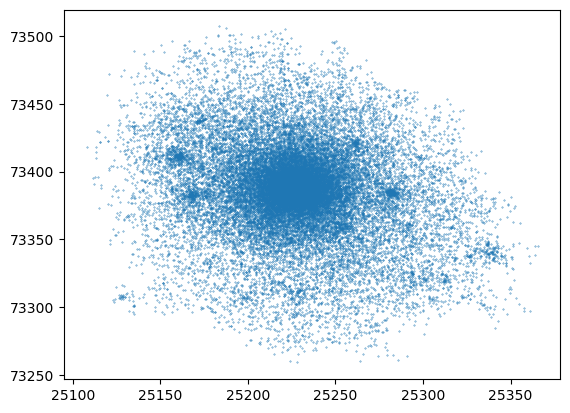

In [9]:
plt.scatter(example[:, 0], example[:, 1], s=0.1)